In [1]:
EXE_ENV_LOCAL = "LOC"
EXE_ENV_GCP = "GCP"

EXE_ENV = EXE_ENV_GCP # Exe Environment


pkl_file_name = "bt-v5-init20240701-epoch100-steph4-batch16-train180.pkl"

prophet_model_dir = 'bt-v5-init20240701-epoch100-steph4-batch16-train180/'

# 1. Install and Import Libraries

## 1.1 Install Libararies

## 1.2 Import Libraries

In [1]:
!pip install Prophet  

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 55.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import os, sys
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import save_model,load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error


# Prophet model for timeseries forecast
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric,plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics


# Visulization
import seaborn as sns
import matplotlib.pyplot as plt

def split_data_by_cutoff_point(df, test_rows = 120): # Forcast next 5 days * 24 hrs = 120 hrs (rows)
    data = df.copy()
    
    total_rows = len(data)  
    split_point = total_rows -  test_rows
    
    train = data[:split_point]
    test = data[split_point:]
    return train, test
    
# Constants
HORIZON_DAYS = 5 # Forcast next 5 days
HORIZON_HOURS = HORIZON_DAYS * 24

In [4]:
var_target = ['y']
var_datetime = ['ds']

In [5]:
selected_features_vif_filtered = ['sentiment_neutral_lag_2hr', 'bollinger_lower', 
                                  'sentiment_positive_lag_6hr', 
  'sentiment_neutral', 'sentiment_negative_lag_7hr', 'open_price', 'raw_money_flow', 
  'sentiment_neutral_lag_7hr', 'RSI', 'sentiment_neutral_volatility', 
  'sentiment_neutral_lag_3hr', 'MACD_diff', 'num_of_trades', 
  'y_lower', 'bollinger_upper', 'tw_avg_negative', 'sentiment_positive_volatility', 
  'quote_asset_volume', 'sentiment_negative_lag_6hr', 'sentiment_neutral_lag_1hr',
  'MACD', 'MFI', 'sentiment_negative_lag_3hr', 'sentiment_neutral_lag_5hr', 'volume',
  'tw_avg_positive', 'sentiment_negative', 'taker_buy_base_asset_volume', 
  'sentiment_negative_volatility', 'tw_avg_neutral', 'typical_price', 'MACD_signal', 
  'sentiment_neutral_lag_4hr', 'positive_money_flow', 'sentiment_neutral_lag_6hr', 
  'sentiment_negative_lag_5hr', 'sentiment_negative_lag_2hr', 'taker_buy_quote_asset_volume', 
  'y_upper', 'negative_money_flow', 'sentiment_negative_lag_1hr', 'sentiment_negative_lag_4hr']

len(selected_features_vif_filtered)

42

In [6]:
selected_features_top = ['sentiment_neutral_lag_2hr', 'bollinger_lower', 
                         'sentiment_positive_lag_6hr', 'sentiment_positive_lag_1hr', 
                         'sentiment_neutral', 'sentiment_negative_lag_7hr', 
                         'open_price', 'raw_money_flow', 'sentiment_neutral_lag_7hr', 
                         'RSI', 'sentiment_neutral_volatility', 'sentiment_neutral_lag_3hr', 
                         'MACD_diff', 'num_of_trades', 'y_lower', 
                         'bollinger_upper', 'tw_avg_negative', 'sentiment_positive_volatility', 
                         'quote_asset_volume', 'sentiment_negative_lag_6hr', 'sentiment_neutral_lag_1hr', 
                         'MACD', 'MFI', 'sentiment_positive_momentum', 'sentiment_negative_momentum', 
                         'sentiment_negative_lag_3hr', 'sentiment_neutral_lag_5hr', 'volume', 
                         'tw_avg_positive', 'sentiment_negative', 
                         'taker_buy_base_asset_volume', 'sentiment_negative_volatility', 
                         'tw_avg_neutral', 'typical_price', 'MACD_signal', 
                         'sentiment_neutral_lag_4hr', 'positive_money_flow', 'sentiment_neutral_lag_6hr',
                         'sentiment_negative_lag_5hr', 'sentiment_negative_lag_2hr',
                         'sentiment_positive_lag_7hr', 'taker_buy_quote_asset_volume', 
                         'y_upper', 'sentiment_neutral_momentum', 'sentiment_positive', 
                         'negative_money_flow', 'sentiment_negative_lag_1hr', 'sentiment_negative_lag_4hr']

len(selected_features_top)

48

In [7]:
selected_features = selected_features_vif_filtered

# 1. Load the Data

In [8]:
def load_merged_data(train_test_lstm_file_path, is_gcp=EXE_ENV):
    
    if is_gcp == EXE_ENV_GCP:
     #   gcps = GCPSManager(bucket_name="adsp-capstone-enique-data")
        merged_df = pd.read_csv("train_test_lstm_reddit_data.csv")
    else:
        # Load the data from local
        merged_df = pd.read_csv("train_test_lstm_reddit_data.csv")
        
    removed_cols = ['prophet_yhat', 'prophet_trend', 'prophet_yhat_low', 'prophet_yhat_high', 'prophet_weekly', 'prophet_yearly']
    
    # Check if columns exist before dropping
    existing_removed_cols = [col for col in removed_cols if col in merged_df.columns]
    
    if existing_removed_cols:
        merged_df.drop(columns=existing_removed_cols, inplace=True)
    
    merged_df['ds'] = pd.to_datetime(merged_df['ds'])
    
    return merged_df

merged_df = load_merged_data("train_test_lstm_reddit_data.csv")


# 1. Function to trim the dataset

In [9]:
def trim_historical_dataset(df, 
                 current_datetime_nearest_hr, 
                 train_days, forcast_hours, date_column='ds'):
    """
    Trims the dataset to include data within the specified number of days 
    from the given current time, and add 120hours datapoints
    """
    
    df[date_column] = pd.to_datetime(df[date_column])

    # Define the cutoff date
    cutoff_date = current_datetime_nearest_hr - pd.DateOffset(days=train_days)

    
    # Filter the DataFrame to get data within the specified date range
    filtered_data = df[(df[date_column] > cutoff_date) & \
                       (df[date_column] <= current_datetime_nearest_hr+timedelta(hours=forcast_hours))]
    
    return filtered_data


# 2. Function to prepare the data

In [10]:
def prepare_data(df, 
                 current_datetime_nearest_hr, 
                 n_past, # Number of past hours we want to use to predict the future
                 n_future, # Number of hours we want to predict into the future
                 validation_split=0.2):
    
    # Select the relevant columns and convert to float
    cols = df.columns.to_list()
    if "ds" in cols:
        cols.remove("ds")
        
    df_for_training = df[cols].astype(float)

    # Normalize the dataset
    scaler = StandardScaler()
    df_for_training_scaled = scaler.fit_transform(df_for_training)

    # Define the split point for training and validation data
    split_point = int(len(df_for_training_scaled) * (1 - validation_split))
    train_data = df_for_training_scaled[:split_point]
    val_data = df_for_training_scaled[split_point:]

    # Prepare the training data
    trainX, trainY = [], []
    
    # Reformat input data into a shape: (n_samples x timesteps x n_features)
    for i in range(n_past, len(train_data) - n_future + 1):
        trainX.append(train_data[i - n_past:i, :])
        trainY.append(train_data[i + n_future - 1, -1])  # 'y' is the last column

    trainX, trainY = np.array(trainX), np.array(trainY)

    # Prepare the validation data
    valX, valY = [], []
    
    for i in range(n_past, len(val_data) - n_future + 1):
        valX.append(val_data[i - n_past:i, :])
        valY.append(val_data[i + n_future - 1, -1])  # 'y' is the last column

    valX, valY = np.array(valX), np.array(valY)

    return trainX, trainY, valX, valY, scaler

# 3. Function to build Prophet model

In [11]:
prophet_model_counter = 0

def build_prophet_model(train_df, best_params_prophet, n_future):
 
    best_model_prophet = Prophet(**best_params_prophet)
    best_model_prophet.fit(train_df)
    
    # Make future dataframe for the next n_future periods with hourly frequency
    future_best = best_model_prophet.make_future_dataframe(periods=n_future, freq='H')
    
    # Predict the future
    forecast_best = best_model_prophet.predict(future_best)
    
    # Define the renaming dictionary
    renamed_cols = {
        'yhat': 'prophet_yhat',
        'trend': 'prophet_trend',
        'yhat_lower': 'prophet_yhat_low',
        'yhat_upper': 'prophet_yhat_high',
        'weekly': 'prophet_weekly',
    }
    
    # Select relevant forecasted features from Prophet
    selected_features = ['ds', 'yhat', 'trend', 'yhat_lower', 'yhat_upper', 'weekly']
    
    if 'yearly' in forecast_best.columns:
        selected_features.append('yearly')
        renamed_cols['yearly'] = 'prophet_yearly'
    if 'daily' in forecast_best.columns:
        selected_features.append('daily')
        renamed_cols['daily'] = 'prophet_daily'
    
    # Merge forecasted data from Prophet model
    forecast_best_selected = forecast_best[selected_features].rename(columns=renamed_cols).copy()
    
    # Declare a counter to keep track of the number of Prophet models
    global prophet_model_counter
    
    
    # Save prophet model, name it with counter
    with open(f'{prophet_model_dir}prophet_model_{prophet_model_counter}.json', 'w') as fout:
        fout.write(model_to_json(best_model_prophet))

    prophet_model_counter += 1
    
    return forecast_best_selected

# 4. Function to build and train LSTM model

In [12]:
def build_and_train_lstm(X_train, y_train, X_val, y_val, input_shape, epochs=100, batch_size=32, patience=10, verbose=1):
    """
    Build and train an LSTM model.

    Parameters:
    - X_train (ndarray): Training features.
    - y_train (ndarray): Training target values.
    - X_val (ndarray): Validation features.
    - y_val (ndarray): Validation target values.
    - input_shape (tuple): Shape of the input data (time steps, number of features).
    - epochs (int): Number of epochs for training.
    - batch_size (int): Batch size for training.
    - patience (int): Patience for early stopping.
    - verbose (int): Verbosity level of the training process.

    Returns:
    - model: Trained LSTM model.
    - history: Training history object.
    """
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(50))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(1))  # Output layer for 'y'

    # Compile the model
    model_lstm.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # Implement early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Train the model
    history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=verbose)
    
    return model_lstm, history

# 5. Function to predict future values and calculate error metrics

In [13]:
def predict_and_evaluate(model, valX, scaler, df_for_training, test_data, n_future):
    print(n_future)
    predict_period_dates = pd.date_range(start=test_data['ds'].min(), periods=n_future, freq='H').tolist()
    
    print(df_for_training.shape)
    test_data.drop(columns = ["ds"], inplace=True)
    df_for_training.drop(columns = ["ds"], inplace=True)
            
            
    # Make prediction using the last sequence from the validation set
    prediction = []
    current_sequence = valX[-1].reshape(1, valX.shape[1], valX.shape[2])

    for _ in range(n_future):
        pred = model.predict(current_sequence)[0, 0]
        prediction.append(pred)

        # Update the sequence with the new prediction
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, -1] = pred

    # Convert predictions to numpy array
    prediction = np.array(prediction).reshape(-1, 1)
    
    # Ensure the number of features matches the original data used for scaling
#     n_features = df_for_training.shape[1]
#     repeated_prediction = np.repeat(prediction, n_features, axis=-1)
#     y_pred_future = scaler.inverse_transform(repeated_prediction)[:, -1]
    
    # Perform inverse transformation to rescale back to original range
    y_pred_future = scaler.inverse_transform(np.repeat(prediction, 
                                                       df_for_training.shape[1], axis=-1))[:, -1]  # 'y' is the last column

    
    print("===================2")

    # Ensure that the length of y_pred_future matches predict_period_dates
    if len(y_pred_future) != len(predict_period_dates):
        print("Length mismatch: y_pred_future and predict_period_dates")
        print(f"Length of y_pred_future: {len(y_pred_future)}")
        print(f"Length of predict_period_dates: {len(predict_period_dates)}")
        
    print(f"===================2=={len(y_pred_future)}")

    # Convert timestamp to date
    df_forecast = pd.DataFrame({'ds': np.array(predict_period_dates[:len(y_pred_future)]), 'y': y_pred_future})
    df_forecast['ds'] = pd.to_datetime(df_forecast['ds'])
    print("===================3")
    # Compute error metrics
    testY = test_data['y'].values
    predictions = df_forecast['y'].values
    print(f"===================5{len(testY)}")
    mse = mean_squared_error(testY, predictions)
    mae = mean_absolute_error(testY, predictions)
    mape = mean_absolute_percentage_error(testY, predictions)
    rmspe = np.sqrt(np.mean(np.square((testY - predictions) / testY))) * 100
    
    # If prediction change and test change in the same direction
    pred_cng = np.diff(predictions)
    
    # Remove nan values
    pred_cng = pred_cng[~np.isnan(pred_cng)]
    
    test_cng = np.diff(testY)
    # Remove nan values
    test_cng = test_cng[~np.isnan(test_cng)]
    
    pred_test_cng = pred_cng * test_cng
    # Count the number of times the prediction and test change in the same direction
    count_same = np.count_nonzero(pred_test_cng > 0)
    
    pcg_same_dir = count_same / len(test_cng)
    
    
    # Standard deviation of error
    std_error = np.std(np.abs(testY - predictions))
    
    print(f"===================5{len(testY)}")
    return mse, mae, mape, testY, predictions, std_error, rmspe, pcg_same_dir


# ** Main function to perform the step-by-step training, prediction, and backtesting


In [14]:
def stepwise_training_and_prediction(merged_df, 
                                     selected_features,
                                     initial_datetime, 
                                     end_datetime,
                                     n_past, 
                                     n_future=120, 
                                     train_days=180,
                                     step_hours=6, 
                                     validation_split=0.2, 
                                     epochs=100, 
                                     batch_size=32, 
                                     patience=10, 
                                     verbose=1):
    
    current_datetime = pd.to_datetime(initial_datetime).floor('H')
    end_datetime = pd.to_datetime(end_datetime).floor('H')

    results = []
    
    selected_features_1 = selected_features + var_datetime+ var_target

    while current_datetime <= end_datetime:
        print(f'Current datetime: {current_datetime}')
        
        # 1. Trim dataset to get train (including validation data) and true_future_df
        dfs = trim_historical_dataset(merged_df, current_datetime, train_days, forcast_hours=n_future)

        # 2. Split dataset into training (including validation data) and true_future_df
        training_df, true_future_df = split_data_by_cutoff_point(dfs, test_rows=n_future)
       
        training_start = training_df['ds'].min()
        training_end = training_df['ds'].max()
        mystery_start = true_future_df['ds'].min()
        mystery_end = true_future_df['ds'].max()
        
        # 3. Train Prophet model
        best_params_prophet = {
            'weekly_seasonality': True, 
            'interval_width': 0.95,
            'seasonality_mode': 'multiplicative', 
            'changepoint_prior_scale': 0.6,
            'seasonality_prior_scale': 0.01, 
            'changepoint_range': 0.76
        }
        
        prophet_predictions = build_prophet_model(training_df, best_params_prophet, n_future)
        
        true_future_df = true_future_df[selected_features_1].copy()
        
        # Merge Prophet predictions with training_df
        training_df = training_df.merge(prophet_predictions, on='ds')
        
        # Add Prophet prediction columns to selected features
        prophet_features = [col for col in prophet_predictions.columns if col != 'ds']
        selected_features_2 = prophet_features + selected_features_1
        
        # Feature selection:
        training_df = training_df[selected_features_2].copy()
        
        
        #print(true_future_df.columns)
        
        # 4. Train LSTM model
        
         # Prepare data for the current window
        trainX, trainY, valX, valY, scaler = prepare_data(training_df, current_datetime, 
                                                          n_past, n_future, validation_split)

        # Define input shape
        input_shape = (trainX.shape[1], trainX.shape[2])

        # Build and train the model
        model_lstm, history = build_and_train_lstm(trainX, trainY, valX, valY, input_shape, epochs, batch_size, patience, verbose)

        # Predict and evaluate
        mse, mae, mape, testY, predictions, std_error, rmspe, pcg_same_dir = predict_and_evaluate(model_lstm, 
                                                                  valX,
                                                                  scaler, 
                                                                  training_df,
                                                                  true_future_df, 
                                                                  n_future)
        
        temp_result = {
            'current_datetime': initial_datetime,
            'training_start': training_start,
            'training_end': training_end,
            'validation_size': len(valX),
            'mystery_start': mystery_start,
            'mystery_end': mystery_end,
            'prophet_predictions':prophet_predictions,
            'y': testY,
            'yhat':predictions,
            'mse': mse,
            'mae': mae,
            'mape': mape,
            'std_error': std_error,
            'rmspe': rmspe,
            'pcg_same_dir': pcg_same_dir
        }

        results.append(temp_result)
        
        print({
            'current_datetime': initial_datetime,
            'training_start': training_start,
            'training_end': training_end,
            'validation_size': len(valX),
            'mystery_start': mystery_start,
            'mystery_end': mystery_end,
            'mse': mse,
            'mae': mae,
            'mape': mape,
            'std_error': std_error,
            'rmspe': rmspe,
            'prophet_predictions':prophet_predictions,
            'pcg_same_dir': pcg_same_dir
        })

        
        # Step forward in time
        current_datetime += pd.Timedelta(hours=step_hours)
        

    results_df = pd.DataFrame(results)
    results_df.to_pickle(pkl_file_name)
    return results



# 6. Starting.......

In [16]:
initial_datetime = pd.to_datetime('2024-07-01 12:00:00')
end_datetime = pd.to_datetime('2024-07-20 23:15')

# Execute the function
results =  stepwise_training_and_prediction(merged_df, 
                                     selected_features,
                                     initial_datetime, 
                                     end_datetime,
                                     n_past=120 * 3, 
                                     n_future=HORIZON_HOURS, 
                                     train_days=180,
                                     step_hours=6, 
                                     validation_split=0.2, 
                                     epochs=100, 
                                     batch_size=16, 
                                     patience=10, 
                                     verbose=1)


Current datetime: 2024-07-01 12:00:00


19:15:28 - cmdstanpy - INFO - Chain [1] start processing
19:15:31 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 61.8661 - val_loss: 83.8916
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 44.4869 - val_loss: 114.9535
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 42.0236 - val_loss: 133.0303
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 35.3814 - val_loss: 158.1161
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 34.1869 - val_loss: 97.6663
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 30.9093 - val_loss: 84.5171
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 26.2444 - val_loss: 121.4497
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 24.8857 - val_loss: 121.7365
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 24.3909 - val_loss: 119.4807
Epoch 10/100
187/187 [==============================] - 4s

19:16:30 - cmdstanpy - INFO - Chain [1] start processing
19:16:32 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 58.7609 - val_loss: 182.6836
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 44.8317 - val_loss: 128.5018
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 39.9788 - val_loss: 88.9891
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 35.3933 - val_loss: 151.1228
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 31.2438 - val_loss: 129.4028
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 28.0841 - val_loss: 133.7768
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 24.9682 - val_loss: 157.8859
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 22.6562 - val_loss: 145.1115
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 22.1666 - val_loss: 201.6592
Epoch 10/100
187/187 [==============================] - 

19:17:38 - cmdstanpy - INFO - Chain [1] start processing
19:17:41 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 59.7172 - val_loss: 97.0683
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 43.5207 - val_loss: 97.0507
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 38.7586 - val_loss: 112.0931
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 33.1643 - val_loss: 148.5331
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 27.7210 - val_loss: 184.7133
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 26.0324 - val_loss: 196.2641
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 22.6844 - val_loss: 173.2299
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 20.6189 - val_loss: 185.3740
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 19.7581 - val_loss: 136.4829
Epoch 10/100
187/187 [==============================] - 4

19:18:45 - cmdstanpy - INFO - Chain [1] start processing
19:18:47 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 60.5006 - val_loss: 86.4001
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 44.9824 - val_loss: 111.3792
Epoch 3/100
187/187 [==============================] - 4s 22ms/step - loss: 39.4106 - val_loss: 79.2326
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 35.1816 - val_loss: 100.1382
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 30.0710 - val_loss: 93.7379
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 26.2631 - val_loss: 100.9758
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 23.3930 - val_loss: 196.5514
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 21.7177 - val_loss: 179.9462
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 19.3933 - val_loss: 220.1471
Epoch 10/100
187/187 [==============================] - 4s

19:19:54 - cmdstanpy - INFO - Chain [1] start processing
19:19:56 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 61.8522 - val_loss: 115.9566
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 44.7496 - val_loss: 127.0636
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 39.1494 - val_loss: 105.5812
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 36.8001 - val_loss: 114.7297
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 34.5225 - val_loss: 128.1001
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 29.5594 - val_loss: 152.8660
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 25.8575 - val_loss: 185.6261
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 22.5308 - val_loss: 160.2045
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 23.9085 - val_loss: 197.1333
Epoch 10/100
187/187 [==============================] -

19:21:04 - cmdstanpy - INFO - Chain [1] start processing
19:21:06 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 65.1418 - val_loss: 77.5789
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 50.4131 - val_loss: 95.0366
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 47.3131 - val_loss: 146.3517
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 42.2519 - val_loss: 109.9802
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 42.8792 - val_loss: 92.6003
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 35.7963 - val_loss: 130.4747
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 34.9852 - val_loss: 215.4478
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 31.9896 - val_loss: 262.7775
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 35.9795 - val_loss: 106.1873
Epoch 10/100
187/187 [==============================] - 4s

19:22:06 - cmdstanpy - INFO - Chain [1] start processing
19:22:08 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 72.9184 - val_loss: 91.0947
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 65.1431 - val_loss: 82.1666
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 58.2177 - val_loss: 101.7211
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 63.1827 - val_loss: 85.7600
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 57.5527 - val_loss: 88.4193
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 56.1732 - val_loss: 91.0703
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 47.9757 - val_loss: 76.8487
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 45.9244 - val_loss: 159.4354
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 41.2378 - val_loss: 163.3842
Epoch 10/100
187/187 [==============================] - 4s 21

19:23:47 - cmdstanpy - INFO - Chain [1] start processing
19:23:50 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 9s 26ms/step - loss: 68.1046 - val_loss: 404.3244
Epoch 2/100
187/187 [==============================] - 4s 22ms/step - loss: 103.5089 - val_loss: 118.1561
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 81.4049 - val_loss: 105.3310
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 66.9436 - val_loss: 97.2264
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 110.8723 - val_loss: 115.8481
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 63.5706 - val_loss: 379.1875
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 165.1403 - val_loss: 96.9318
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 84.8655 - val_loss: 110.9552
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 75.0971 - val_loss: 168.3253
Epoch 10/100
187/187 [==============================] 

19:25:14 - cmdstanpy - INFO - Chain [1] start processing
19:25:17 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 66.6148 - val_loss: 154.4200
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 52.0819 - val_loss: 150.2809
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 40.3928 - val_loss: 246.1643
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 42.3008 - val_loss: 201.3564
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 42.4487 - val_loss: 184.9364
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 39.9694 - val_loss: 218.0815
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 33.8973 - val_loss: 300.7210
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 29.9924 - val_loss: 315.8427
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 29.5725 - val_loss: 336.4999
Epoch 10/100
187/187 [==============================] -

19:26:20 - cmdstanpy - INFO - Chain [1] start processing
19:26:23 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 9s 26ms/step - loss: 63.5212 - val_loss: 180.7614
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 53.1644 - val_loss: 169.1568
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 43.2818 - val_loss: 145.9313
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 38.8911 - val_loss: 205.8617
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 44.6109 - val_loss: 157.7529
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 43.6876 - val_loss: 152.8683
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 38.2588 - val_loss: 196.2028
Epoch 8/100
187/187 [==============================] - 4s 22ms/step - loss: 35.5484 - val_loss: 279.8751
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 32.7542 - val_loss: 306.4774
Epoch 10/100
187/187 [==============================] -

19:27:31 - cmdstanpy - INFO - Chain [1] start processing
19:27:34 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 67.3388 - val_loss: 839.2665
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 53.1510 - val_loss: 744.1594
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 49.1123 - val_loss: 628.6785
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 42.6335 - val_loss: 645.2260
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 42.4505 - val_loss: 532.1394
Epoch 6/100
187/187 [==============================] - 4s 22ms/step - loss: 33.1486 - val_loss: 595.3455
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 37.2108 - val_loss: 724.1154
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 41.1656 - val_loss: 866.0918
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 34.6053 - val_loss: 965.6830
Epoch 10/100
187/187 [==============================] -

19:28:49 - cmdstanpy - INFO - Chain [1] start processing
19:28:52 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 83.4873 - val_loss: 285.8406
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 125.5042 - val_loss: 510.8286
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 122.4633 - val_loss: 341.4084
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 122.1490 - val_loss: 1158.1547
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 99.9729 - val_loss: 825.2497
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 177.3828 - val_loss: 487.3258
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 113.4911 - val_loss: 630.3160
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 244.6914 - val_loss: 222.0833
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 113.8193 - val_loss: 796.1481
Epoch 10/100
187/187 [=========================

19:30:52 - cmdstanpy - INFO - Chain [1] start processing
19:30:55 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 27ms/step - loss: 72.0915 - val_loss: 286.1347
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 65.0551 - val_loss: 251.1665
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 56.3668 - val_loss: 348.0364
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 45.1911 - val_loss: 339.5933
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 49.2967 - val_loss: 231.0143
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 42.5254 - val_loss: 243.2688
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 44.2269 - val_loss: 186.6331
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 32.6692 - val_loss: 293.6896
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 35.4481 - val_loss: 429.9363
Epoch 10/100
187/187 [==============================] -

19:32:19 - cmdstanpy - INFO - Chain [1] start processing
19:32:21 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 66.8292 - val_loss: 225.0364
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 55.0715 - val_loss: 150.1879
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 50.2279 - val_loss: 124.8065
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 44.3873 - val_loss: 231.3787
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 43.7372 - val_loss: 241.6834
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 39.0282 - val_loss: 257.9326
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 33.8145 - val_loss: 347.5220
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 30.7250 - val_loss: 634.1142
Epoch 9/100
187/187 [==============================] - 4s 22ms/step - loss: 26.9081 - val_loss: 358.9994
Epoch 10/100
187/187 [==============================] -

19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:32 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 71.1825 - val_loss: 216.4371
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 58.8438 - val_loss: 167.4780
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 51.5221 - val_loss: 151.3137
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 45.4344 - val_loss: 168.9789
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 43.1159 - val_loss: 143.9246
Epoch 6/100
187/187 [==============================] - 4s 22ms/step - loss: 37.6072 - val_loss: 235.3518
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 34.3869 - val_loss: 181.6081
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 31.8041 - val_loss: 186.9436
Epoch 9/100
187/187 [==============================] - 4s 22ms/step - loss: 29.6964 - val_loss: 328.0979
Epoch 10/100
187/187 [==============================] -

19:34:48 - cmdstanpy - INFO - Chain [1] start processing
19:34:50 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 79.4176 - val_loss: 347.9835
Epoch 2/100
187/187 [==============================] - 4s 22ms/step - loss: 72.6214 - val_loss: 233.7830
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 62.9451 - val_loss: 314.7936
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 62.2834 - val_loss: 279.2981
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 60.6175 - val_loss: 490.3788
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 46.0093 - val_loss: 370.1904
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 58.5031 - val_loss: 1117.2196
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 57.6436 - val_loss: 643.6863
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 46.0167 - val_loss: 1018.0223
Epoch 10/100
187/187 [==============================]

19:35:53 - cmdstanpy - INFO - Chain [1] start processing
19:35:56 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 9s 26ms/step - loss: 83.8760 - val_loss: 202.9449
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 65.6886 - val_loss: 166.1692
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 71.1767 - val_loss: 326.8320
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 61.6442 - val_loss: 181.4550
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 71.5622 - val_loss: 281.9812
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 79.0686 - val_loss: 145.1985
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 60.2136 - val_loss: 394.9085
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 62.0328 - val_loss: 212.3214
Epoch 9/100
187/187 [==============================] - 4s 22ms/step - loss: 46.7303 - val_loss: 224.2640
Epoch 10/100
187/187 [==============================] -

19:37:16 - cmdstanpy - INFO - Chain [1] start processing
19:37:18 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 78.7734 - val_loss: 204.0208
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 60.3784 - val_loss: 315.9856
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 54.0842 - val_loss: 175.8466
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 56.7829 - val_loss: 138.3859
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 53.9106 - val_loss: 212.2519
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 58.6960 - val_loss: 276.8972
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 48.9936 - val_loss: 257.1700
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 44.7259 - val_loss: 253.2500
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 39.5564 - val_loss: 340.8264
Epoch 10/100
187/187 [==============================] -

19:38:29 - cmdstanpy - INFO - Chain [1] start processing
19:38:32 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 9s 26ms/step - loss: 90.6833 - val_loss: 269.7443
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 71.7234 - val_loss: 373.4555
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 69.1497 - val_loss: 176.9366
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 76.6132 - val_loss: 354.0534
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 78.6640 - val_loss: 186.4448
Epoch 6/100
187/187 [==============================] - 4s 22ms/step - loss: 59.4812 - val_loss: 265.8066
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 80.2942 - val_loss: 221.5696
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 50.5408 - val_loss: 188.8913
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 63.8830 - val_loss: 409.9240
Epoch 10/100
187/187 [==============================] -

19:39:41 - cmdstanpy - INFO - Chain [1] start processing
19:39:43 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 106.1425 - val_loss: 316.5820
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 101.5912 - val_loss: 181.2521
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 72.2255 - val_loss: 264.7444
Epoch 4/100
187/187 [==============================] - 4s 22ms/step - loss: 104.7034 - val_loss: 221.1202
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 165.4735 - val_loss: 423.2535
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 93.7227 - val_loss: 444.9698
Epoch 7/100
187/187 [==============================] - 4s 22ms/step - loss: 77.4066 - val_loss: 658.9161
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 111.3452 - val_loss: 371.2895
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 77.4315 - val_loss: 394.0867
Epoch 10/100
187/187 [============================

19:40:46 - cmdstanpy - INFO - Chain [1] start processing
19:40:48 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 88.8804 - val_loss: 1543.2037
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 81.6744 - val_loss: 743.4577
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 64.5736 - val_loss: 451.7997
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 63.6963 - val_loss: 395.9512
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 68.0102 - val_loss: 1454.4927
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 58.4889 - val_loss: 1970.6753
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 60.9967 - val_loss: 2106.2039
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 52.2487 - val_loss: 2136.7366
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 54.8313 - val_loss: 1580.7521
Epoch 10/100
187/187 [===========================

19:42:01 - cmdstanpy - INFO - Chain [1] start processing
19:42:04 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 76.8592 - val_loss: 361.0204
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 65.6985 - val_loss: 949.9885
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 69.9844 - val_loss: 478.5261
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 64.0405 - val_loss: 331.1183
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 51.0274 - val_loss: 328.2282
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 49.6238 - val_loss: 262.6015
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 48.2924 - val_loss: 771.3057
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 42.3800 - val_loss: 1003.5226
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 45.7944 - val_loss: 762.0430
Epoch 10/100
187/187 [==============================] 

19:43:23 - cmdstanpy - INFO - Chain [1] start processing
19:43:24 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 366.3209 - val_loss: 172.4616
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 130.7264 - val_loss: 845.8523
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 189.1076 - val_loss: 600.9193
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 157.8056 - val_loss: 1098.6731
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 314.9541 - val_loss: 658.2388
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 273.0513 - val_loss: 694.3420
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 203.3087 - val_loss: 617.7576
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 297.4657 - val_loss: 373.5832
Epoch 9/100
187/187 [==============================] - 4s 22ms/step - loss: 138.5330 - val_loss: 1192.4346
Epoch 10/100
187/187 [======================

19:44:25 - cmdstanpy - INFO - Chain [1] start processing
19:44:27 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 95.2141 - val_loss: 404.6268
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 82.5045 - val_loss: 93.9089
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 79.6031 - val_loss: 130.2052
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 64.1053 - val_loss: 263.2850
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 54.9214 - val_loss: 184.1190
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 61.6572 - val_loss: 187.3241
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 52.2713 - val_loss: 330.4446
Epoch 8/100
187/187 [==============================] - 4s 22ms/step - loss: 53.5724 - val_loss: 241.3988
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 50.9017 - val_loss: 463.0283
Epoch 10/100
187/187 [==============================] - 

19:45:31 - cmdstanpy - INFO - Chain [1] start processing
19:45:33 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 86.7490 - val_loss: 440.4616
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 75.2476 - val_loss: 370.0989
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 68.5726 - val_loss: 322.5977
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 67.8542 - val_loss: 318.7291
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 65.4496 - val_loss: 176.5255
Epoch 6/100
187/187 [==============================] - 4s 22ms/step - loss: 63.3844 - val_loss: 292.9137
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 60.6335 - val_loss: 662.6391
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 55.7205 - val_loss: 246.5213
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 53.8890 - val_loss: 302.4472
Epoch 10/100
187/187 [==============================] -

19:46:48 - cmdstanpy - INFO - Chain [1] start processing
19:46:50 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 168.4017 - val_loss: 206.6579
Epoch 2/100
187/187 [==============================] - 4s 22ms/step - loss: 81.3158 - val_loss: 1086.7373
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 108.4901 - val_loss: 944.8059
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 146.9028 - val_loss: 226.0583
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 142.8190 - val_loss: 608.2628
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 92.0770 - val_loss: 671.0134
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 137.9992 - val_loss: 242.6251
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 81.2473 - val_loss: 363.5840
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 96.4917 - val_loss: 228.6905
Epoch 10/100
187/187 [===========================

19:47:50 - cmdstanpy - INFO - Chain [1] start processing
19:47:52 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 123.9962 - val_loss: 232.6549
Epoch 2/100
187/187 [==============================] - 4s 22ms/step - loss: 111.9074 - val_loss: 459.8009
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 101.0201 - val_loss: 371.4369
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 94.5549 - val_loss: 206.0210
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 76.6495 - val_loss: 244.7991
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 76.6805 - val_loss: 238.7565
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 77.5254 - val_loss: 562.4355
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 106.5176 - val_loss: 378.3401
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 94.0793 - val_loss: 312.5334
Epoch 10/100
187/187 [=============================

19:50:13 - cmdstanpy - INFO - Chain [1] start processing
19:50:15 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 9s 26ms/step - loss: 109.8267 - val_loss: 781.6798
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 74.4792 - val_loss: 1171.1619
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 98.8043 - val_loss: 467.4139
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 73.2884 - val_loss: 1376.1078
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 68.1212 - val_loss: 1233.7349
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 73.4234 - val_loss: 1161.5272
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 69.0890 - val_loss: 1075.2056
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 55.7115 - val_loss: 432.3077
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 57.4176 - val_loss: 326.9600
Epoch 10/100
187/187 [===========================

19:52:07 - cmdstanpy - INFO - Chain [1] start processing
19:52:09 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 104.7127 - val_loss: 492.1217
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 107.7292 - val_loss: 273.8862
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 81.6033 - val_loss: 531.1046
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 68.9363 - val_loss: 689.7561
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 75.3156 - val_loss: 498.0048
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 77.5596 - val_loss: 645.1863
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 76.0847 - val_loss: 214.7953
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 80.9002 - val_loss: 169.4604
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 61.3127 - val_loss: 171.0239
Epoch 10/100
187/187 [==============================]

19:53:35 - cmdstanpy - INFO - Chain [1] start processing
19:53:38 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 9s 26ms/step - loss: 86.5820 - val_loss: 186.9001
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 95.0176 - val_loss: 336.3805
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 96.7545 - val_loss: 378.4145
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 85.4106 - val_loss: 503.7443
Epoch 5/100
187/187 [==============================] - 4s 22ms/step - loss: 75.2645 - val_loss: 582.7318
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 65.7222 - val_loss: 441.9261
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 60.9815 - val_loss: 353.9901
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 59.2637 - val_loss: 378.5997
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 57.6898 - val_loss: 408.1705
Epoch 10/100
187/187 [==============================] -

19:54:38 - cmdstanpy - INFO - Chain [1] start processing
19:54:40 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 25ms/step - loss: 93.6860 - val_loss: 983.5901
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 99.5037 - val_loss: 472.2867
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 84.3273 - val_loss: 562.1609
Epoch 4/100
187/187 [==============================] - 4s 22ms/step - loss: 81.8072 - val_loss: 491.1739
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 65.9208 - val_loss: 274.2617
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 79.1107 - val_loss: 341.7686
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 71.2289 - val_loss: 484.1608
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 66.3017 - val_loss: 448.0757
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 62.6305 - val_loss: 504.8771
Epoch 10/100
187/187 [==============================] -

19:55:54 - cmdstanpy - INFO - Chain [1] start processing
19:55:57 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 106.1890 - val_loss: 533.3585
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 104.8633 - val_loss: 1638.9602
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 98.9982 - val_loss: 965.4722
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 105.5807 - val_loss: 985.5633
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 97.6419 - val_loss: 697.5212
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 76.5207 - val_loss: 307.6656
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 98.8539 - val_loss: 378.6727
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 103.0497 - val_loss: 652.8610
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 82.4550 - val_loss: 445.8382
Epoch 10/100
187/187 [============================

19:57:17 - cmdstanpy - INFO - Chain [1] start processing
19:57:20 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 108.2778 - val_loss: 448.9119
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 106.3632 - val_loss: 804.4642
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 113.1534 - val_loss: 333.0748
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 95.2086 - val_loss: 1489.7400
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 121.9927 - val_loss: 389.1928
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 87.3165 - val_loss: 312.0725
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 92.9052 - val_loss: 214.5255
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 86.6590 - val_loss: 343.6953
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 90.1720 - val_loss: 767.4122
Epoch 10/100
187/187 [============================

19:59:19 - cmdstanpy - INFO - Chain [1] start processing
19:59:21 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 1231.9574 - val_loss: 365.2307
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 3991.4749 - val_loss: 411.3911
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 7369.0293 - val_loss: 334.9521
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 9338.8252 - val_loss: 303.5075
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 3290.4641 - val_loss: 249.4113
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 5101.7988 - val_loss: 276.8389
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 5442.1245 - val_loss: 289.0991
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 4973.2285 - val_loss: 561.0256
Epoch 9/100
187/187 [==============================] - 4s 22ms/step - loss: 2090.9204 - val_loss: 186.3868
Epoch 10/100
187/187 [===============

20:01:32 - cmdstanpy - INFO - Chain [1] start processing
20:01:34 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 98.9915 - val_loss: 567.7858
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 88.7000 - val_loss: 1039.4259
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 94.6436 - val_loss: 461.6124
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 84.4665 - val_loss: 850.5663
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 80.6348 - val_loss: 452.3840
Epoch 6/100
187/187 [==============================] - 4s 22ms/step - loss: 82.4440 - val_loss: 469.6217
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 73.1917 - val_loss: 617.3630
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 62.4683 - val_loss: 197.6159
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 75.0454 - val_loss: 420.5053
Epoch 10/100
187/187 [==============================] 

20:03:01 - cmdstanpy - INFO - Chain [1] start processing
20:03:03 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 86.0531 - val_loss: 171.1516
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 90.9790 - val_loss: 323.7701
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 82.3084 - val_loss: 466.0409
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 70.1010 - val_loss: 627.1052
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 74.9393 - val_loss: 479.1225
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 67.0122 - val_loss: 387.5577
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 80.0952 - val_loss: 638.4848
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 59.5549 - val_loss: 995.7495
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 74.3735 - val_loss: 583.9480
Epoch 10/100
187/187 [==============================] -

20:04:02 - cmdstanpy - INFO - Chain [1] start processing
20:04:04 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 9s 26ms/step - loss: 105.4378 - val_loss: 256.2679
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 274.6117 - val_loss: 170.4303
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 360.7190 - val_loss: 256.1449
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 132.3828 - val_loss: 378.4965
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 791.4966 - val_loss: 235.7822
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 274.3207 - val_loss: 293.3767
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 635.7488 - val_loss: 181.5367
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 215.9375 - val_loss: 183.0200
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 125.2183 - val_loss: 471.5629
Epoch 10/100
187/187 [========================

20:05:08 - cmdstanpy - INFO - Chain [1] start processing
20:05:10 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 88.3572 - val_loss: 384.0337
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 81.4242 - val_loss: 262.2177
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 66.0731 - val_loss: 363.8431
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 61.8771 - val_loss: 468.4450
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 64.6193 - val_loss: 674.0066
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 60.0073 - val_loss: 667.9716
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 56.2315 - val_loss: 911.4326
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 63.3784 - val_loss: 936.1482
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 45.8574 - val_loss: 877.4051
Epoch 10/100
187/187 [==============================] -

20:06:13 - cmdstanpy - INFO - Chain [1] start processing
20:06:15 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 97.5074 - val_loss: 1591.1053
Epoch 2/100
187/187 [==============================] - 5s 25ms/step - loss: 81.3392 - val_loss: 651.0697
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 73.6404 - val_loss: 756.3880
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 65.1743 - val_loss: 877.3476
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 62.6149 - val_loss: 2068.0933
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 50.8416 - val_loss: 2418.3196
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 47.2039 - val_loss: 865.2178
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 40.0930 - val_loss: 1695.9729
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 38.6920 - val_loss: 1472.8879
Epoch 10/100
187/187 [============================

20:07:19 - cmdstanpy - INFO - Chain [1] start processing
20:07:21 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 89.5982 - val_loss: 229.6613
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 108.1688 - val_loss: 186.3391
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 112.6705 - val_loss: 164.1439
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 111.1847 - val_loss: 312.6436
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 113.9397 - val_loss: 330.8463
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 102.4971 - val_loss: 504.3171
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 81.4423 - val_loss: 635.3278
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 103.8318 - val_loss: 336.2151
Epoch 9/100
187/187 [==============================] - 4s 22ms/step - loss: 67.6695 - val_loss: 397.8886
Epoch 10/100
187/187 [===========================

20:08:28 - cmdstanpy - INFO - Chain [1] start processing
20:08:30 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 25ms/step - loss: 95.2155 - val_loss: 172.0004
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 86.9784 - val_loss: 184.6347
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 81.8014 - val_loss: 255.8762
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 84.3969 - val_loss: 178.5744
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 78.3587 - val_loss: 347.2835
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 63.3502 - val_loss: 320.0630
Epoch 7/100
187/187 [==============================] - 4s 22ms/step - loss: 57.0196 - val_loss: 522.6818
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 53.6158 - val_loss: 265.0865
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 55.5612 - val_loss: 309.6665
Epoch 10/100
187/187 [==============================] -

20:09:30 - cmdstanpy - INFO - Chain [1] start processing
20:09:32 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 97.0446 - val_loss: 210.0985
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 88.5653 - val_loss: 315.5139
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 86.9005 - val_loss: 363.9226
Epoch 4/100
187/187 [==============================] - 4s 22ms/step - loss: 92.2632 - val_loss: 631.1974
Epoch 5/100
187/187 [==============================] - 4s 22ms/step - loss: 79.3126 - val_loss: 715.7490
Epoch 6/100
187/187 [==============================] - 4s 22ms/step - loss: 87.3811 - val_loss: 475.9413
Epoch 7/100
187/187 [==============================] - 4s 22ms/step - loss: 67.3353 - val_loss: 689.2951
Epoch 8/100
187/187 [==============================] - 4s 22ms/step - loss: 75.3770 - val_loss: 378.7943
Epoch 9/100
187/187 [==============================] - 4s 22ms/step - loss: 62.5616 - val_loss: 306.0142
Epoch 10/100
187/187 [==============================] -

20:10:32 - cmdstanpy - INFO - Chain [1] start processing
20:10:35 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 91.9630 - val_loss: 319.3187
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 83.1493 - val_loss: 262.9435
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 76.1835 - val_loss: 308.5815
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 69.1977 - val_loss: 153.3053
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 66.2239 - val_loss: 458.9129
Epoch 6/100
187/187 [==============================] - 4s 22ms/step - loss: 57.5249 - val_loss: 124.9368
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 48.4946 - val_loss: 273.3008
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 48.6356 - val_loss: 330.2614
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 44.5803 - val_loss: 203.1255
Epoch 10/100
187/187 [==============================] -

20:11:54 - cmdstanpy - INFO - Chain [1] start processing
20:11:56 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 9s 26ms/step - loss: 108.0919 - val_loss: 474.5102
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 86.9982 - val_loss: 298.2389
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 89.0576 - val_loss: 259.2782
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 95.0851 - val_loss: 288.0389
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 73.4994 - val_loss: 236.4326
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 64.9817 - val_loss: 494.6985
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 74.6922 - val_loss: 533.6002
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 62.5038 - val_loss: 376.6838
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 62.2921 - val_loss: 233.0157
Epoch 10/100
187/187 [==============================] 

20:13:44 - cmdstanpy - INFO - Chain [1] start processing
20:13:46 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 94.1509 - val_loss: 141.3878
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 71.4428 - val_loss: 211.0916
Epoch 3/100
187/187 [==============================] - 4s 22ms/step - loss: 69.3740 - val_loss: 327.3311
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 70.6527 - val_loss: 469.5178
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 57.3347 - val_loss: 257.3728
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 48.2266 - val_loss: 161.3737
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 44.1590 - val_loss: 138.9448
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 43.6332 - val_loss: 224.8021
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 40.6185 - val_loss: 207.0089
Epoch 10/100
187/187 [==============================] -

20:15:37 - cmdstanpy - INFO - Chain [1] start processing
20:15:39 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 9s 26ms/step - loss: 110.1595 - val_loss: 303.3554
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 90.0475 - val_loss: 244.2774
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 75.5374 - val_loss: 557.1293
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 92.2538 - val_loss: 208.8705
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 90.7322 - val_loss: 186.9261
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 81.4287 - val_loss: 452.0129
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 86.1076 - val_loss: 192.6254
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 74.5277 - val_loss: 220.7721
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 72.0681 - val_loss: 305.3449
Epoch 10/100
187/187 [==============================] 

20:18:06 - cmdstanpy - INFO - Chain [1] start processing
20:18:08 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 25ms/step - loss: 91.3191 - val_loss: 156.7256
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 75.7822 - val_loss: 260.8892
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 66.5175 - val_loss: 254.6617
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 60.6595 - val_loss: 381.8121
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 58.5010 - val_loss: 504.9771
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 50.4105 - val_loss: 543.0428
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 47.5783 - val_loss: 696.4287
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 51.6617 - val_loss: 501.5995
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 42.9121 - val_loss: 646.3674
Epoch 10/100
187/187 [==============================] -

20:19:07 - cmdstanpy - INFO - Chain [1] start processing
20:19:09 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 25ms/step - loss: 122.5083 - val_loss: 179.8325
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 108.4700 - val_loss: 170.7311
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 104.0210 - val_loss: 261.1856
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 92.2399 - val_loss: 208.7648
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 76.9947 - val_loss: 357.4572
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 73.1563 - val_loss: 323.5139
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 83.9761 - val_loss: 164.0574
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 75.8602 - val_loss: 197.0856
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 55.3684 - val_loss: 295.6654
Epoch 10/100
187/187 [==============================

20:20:33 - cmdstanpy - INFO - Chain [1] start processing
20:20:35 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 25ms/step - loss: 122.0833 - val_loss: 211.9231
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 92.0259 - val_loss: 118.1473
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 87.6055 - val_loss: 132.2979
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 73.3749 - val_loss: 180.7603
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 72.7867 - val_loss: 195.0950
Epoch 6/100
187/187 [==============================] - 4s 22ms/step - loss: 69.3362 - val_loss: 205.8532
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 55.8996 - val_loss: 212.5397
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 57.4555 - val_loss: 183.0450
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 54.2321 - val_loss: 149.6066
Epoch 10/100
187/187 [==============================] 

20:21:38 - cmdstanpy - INFO - Chain [1] start processing
20:21:40 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 25ms/step - loss: 149.6878 - val_loss: 209.4933
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 116.3390 - val_loss: 129.8978
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 111.7310 - val_loss: 233.1370
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 92.3254 - val_loss: 99.9910
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 85.5777 - val_loss: 193.0833
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 72.4582 - val_loss: 193.9364
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 70.4753 - val_loss: 138.6848
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 61.0813 - val_loss: 417.4352
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 63.5407 - val_loss: 239.9031
Epoch 10/100
187/187 [==============================]

20:22:50 - cmdstanpy - INFO - Chain [1] start processing
20:22:52 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 176.0232 - val_loss: 188.9513
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 146.0450 - val_loss: 329.9642
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 485.7178 - val_loss: 305.2375
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 211.4075 - val_loss: 334.3664
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 179.7377 - val_loss: 842.9227
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 469.6307 - val_loss: 193.2466
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 141.8909 - val_loss: 710.7911
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 662.0317 - val_loss: 128.7510
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 243.6527 - val_loss: 352.5556
Epoch 10/100
187/187 [========================

20:24:43 - cmdstanpy - INFO - Chain [1] start processing
20:24:45 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 25ms/step - loss: 149.0216 - val_loss: 431.5228
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 124.4423 - val_loss: 333.6826
Epoch 3/100
187/187 [==============================] - 4s 22ms/step - loss: 118.9300 - val_loss: 785.0984
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 104.9095 - val_loss: 336.9776
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 95.1181 - val_loss: 311.5329
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 92.2674 - val_loss: 730.7609
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 83.3840 - val_loss: 489.9629
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 84.7144 - val_loss: 784.3255
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 88.5366 - val_loss: 344.4925
Epoch 10/100
187/187 [=============================

20:26:00 - cmdstanpy - INFO - Chain [1] start processing
20:26:02 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 9s 26ms/step - loss: 185.0728 - val_loss: 493.3824
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 214.5526 - val_loss: 515.7711
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 208.5540 - val_loss: 296.9009
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 139.2416 - val_loss: 426.6562
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 159.3841 - val_loss: 497.0155
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 136.4091 - val_loss: 346.4337
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 148.2943 - val_loss: 251.6614
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 114.6908 - val_loss: 505.9791
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 141.6900 - val_loss: 268.2047
Epoch 10/100
187/187 [========================

20:27:57 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 26ms/step - loss: 193.8611 - val_loss: 341.2350
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 134.2685 - val_loss: 392.8297
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 197.6434 - val_loss: 163.0412
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 119.9818 - val_loss: 689.0043
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 168.4025 - val_loss: 221.6564
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 160.9922 - val_loss: 169.8315
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 110.7194 - val_loss: 216.5639
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 112.2110 - val_loss: 139.2851
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 106.9465 - val_loss: 210.6923
Epoch 10/100
187/187 [========================

20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:28 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 9s 26ms/step - loss: 157.4692 - val_loss: 504.4612
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 177.9441 - val_loss: 492.1732
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 130.6648 - val_loss: 364.0158
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 191.9678 - val_loss: 307.0162
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 135.0014 - val_loss: 296.8376
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 182.4320 - val_loss: 379.9329
Epoch 7/100
187/187 [==============================] - 4s 22ms/step - loss: 136.8261 - val_loss: 495.1423
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 148.4098 - val_loss: 413.7400
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 132.3596 - val_loss: 361.4777
Epoch 10/100
187/187 [========================

20:31:08 - cmdstanpy - INFO - Chain [1] start processing
20:31:10 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 25ms/step - loss: 185.3337 - val_loss: 1056.8835
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 233.8881 - val_loss: 345.4287
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 212.9057 - val_loss: 375.7269
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 188.0260 - val_loss: 1695.3995
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 214.5479 - val_loss: 1115.8550
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 170.5130 - val_loss: 1398.0958
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 235.1869 - val_loss: 866.8118
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 125.0197 - val_loss: 2235.8328
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 192.1633 - val_loss: 815.1070
Epoch 10/100
187/187 [===================

20:32:13 - cmdstanpy - INFO - Chain [1] start processing
20:32:15 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 25ms/step - loss: 149.3092 - val_loss: 257.5068
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 150.7045 - val_loss: 241.5418
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 191.5729 - val_loss: 315.8400
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 124.6049 - val_loss: 416.1232
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 173.0874 - val_loss: 319.0790
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 99.3938 - val_loss: 358.4380
Epoch 7/100
187/187 [==============================] - 5s 25ms/step - loss: 173.2278 - val_loss: 231.4904
Epoch 8/100
187/187 [==============================] - 4s 21ms/step - loss: 127.2590 - val_loss: 534.6088
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 129.5641 - val_loss: 707.0266
Epoch 10/100
187/187 [=========================

20:34:22 - cmdstanpy - INFO - Chain [1] start processing
20:34:25 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
187/187 [==============================] - 8s 25ms/step - loss: 211.3822 - val_loss: 288.0017
Epoch 2/100
187/187 [==============================] - 4s 21ms/step - loss: 253.0680 - val_loss: 185.3407
Epoch 3/100
187/187 [==============================] - 4s 21ms/step - loss: 190.0301 - val_loss: 184.1365
Epoch 4/100
187/187 [==============================] - 4s 21ms/step - loss: 155.0391 - val_loss: 392.8373
Epoch 5/100
187/187 [==============================] - 4s 21ms/step - loss: 165.4024 - val_loss: 298.4741
Epoch 6/100
187/187 [==============================] - 4s 21ms/step - loss: 124.5700 - val_loss: 323.2490
Epoch 7/100
187/187 [==============================] - 4s 21ms/step - loss: 114.8001 - val_loss: 294.6242
Epoch 8/100
187/187 [==============================] - 4s 22ms/step - loss: 149.2044 - val_loss: 150.0421
Epoch 9/100
187/187 [==============================] - 4s 21ms/step - loss: 130.8066 - val_loss: 184.1565
Epoch 10/100
187/187 [========================

20:35:51 - cmdstanpy - INFO - Chain [1] start processing
20:35:54 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
186/186 [==============================] - 8s 26ms/step - loss: 209.7865 - val_loss: 422.2378
Epoch 2/100
186/186 [==============================] - 4s 20ms/step - loss: 212.9189 - val_loss: 358.1410
Epoch 3/100
186/186 [==============================] - 4s 20ms/step - loss: 159.2168 - val_loss: 383.9292
Epoch 4/100
186/186 [==============================] - 4s 20ms/step - loss: 319.9852 - val_loss: 273.2376
Epoch 5/100
186/186 [==============================] - 4s 20ms/step - loss: 182.5791 - val_loss: 385.4518
Epoch 6/100
186/186 [==============================] - 4s 20ms/step - loss: 191.5309 - val_loss: 386.6257
Epoch 7/100
186/186 [==============================] - 4s 20ms/step - loss: 170.9982 - val_loss: 204.9229
Epoch 8/100
186/186 [==============================] - 4s 20ms/step - loss: 179.5587 - val_loss: 257.2314
Epoch 9/100
186/186 [==============================] - 4s 20ms/step - loss: 176.8253 - val_loss: 137.8795
Epoch 10/100
186/186 [========================

20:37:21 - cmdstanpy - INFO - Chain [1] start processing
20:37:23 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
186/186 [==============================] - 8s 26ms/step - loss: 334.3116 - val_loss: 144.3360
Epoch 2/100
186/186 [==============================] - 4s 21ms/step - loss: 547.6147 - val_loss: 324.6748
Epoch 3/100
186/186 [==============================] - 4s 21ms/step - loss: 449.4419 - val_loss: 177.8775
Epoch 4/100
186/186 [==============================] - 4s 21ms/step - loss: 477.0477 - val_loss: 356.6510
Epoch 5/100
186/186 [==============================] - 4s 21ms/step - loss: 1356.0183 - val_loss: 332.3215
Epoch 6/100
186/186 [==============================] - 4s 21ms/step - loss: 426.9085 - val_loss: 317.4716
Epoch 7/100
186/186 [==============================] - 4s 21ms/step - loss: 482.0775 - val_loss: 215.1581
Epoch 8/100
186/186 [==============================] - 4s 21ms/step - loss: 260.8964 - val_loss: 567.9616
Epoch 9/100
186/186 [==============================] - 4s 21ms/step - loss: 434.2104 - val_loss: 271.2718
Epoch 10/100
186/186 [=======================

20:38:23 - cmdstanpy - INFO - Chain [1] start processing
20:38:25 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
186/186 [==============================] - 8s 26ms/step - loss: 138.5465 - val_loss: 144.9966
Epoch 2/100
186/186 [==============================] - 4s 21ms/step - loss: 140.0618 - val_loss: 319.6338
Epoch 3/100
186/186 [==============================] - 4s 21ms/step - loss: 114.3268 - val_loss: 213.2905
Epoch 4/100
186/186 [==============================] - 4s 21ms/step - loss: 118.4831 - val_loss: 285.3600
Epoch 5/100
186/186 [==============================] - 4s 21ms/step - loss: 107.0902 - val_loss: 147.8049
Epoch 6/100
186/186 [==============================] - 4s 21ms/step - loss: 105.5486 - val_loss: 245.2964
Epoch 7/100
186/186 [==============================] - 4s 21ms/step - loss: 97.3235 - val_loss: 179.2619
Epoch 8/100
186/186 [==============================] - 4s 21ms/step - loss: 95.6782 - val_loss: 152.4752
Epoch 9/100
186/186 [==============================] - 4s 21ms/step - loss: 94.6759 - val_loss: 268.9110
Epoch 10/100
186/186 [===========================

20:39:23 - cmdstanpy - INFO - Chain [1] start processing
20:39:25 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
186/186 [==============================] - 9s 26ms/step - loss: 164.3710 - val_loss: 171.8732
Epoch 2/100
186/186 [==============================] - 4s 21ms/step - loss: 128.4561 - val_loss: 184.4255
Epoch 3/100
186/186 [==============================] - 4s 21ms/step - loss: 116.7594 - val_loss: 189.1200
Epoch 4/100
186/186 [==============================] - 4s 21ms/step - loss: 120.9279 - val_loss: 225.6452
Epoch 5/100
186/186 [==============================] - 4s 21ms/step - loss: 98.5253 - val_loss: 137.5181
Epoch 6/100
186/186 [==============================] - 4s 21ms/step - loss: 109.8703 - val_loss: 117.9852
Epoch 7/100
186/186 [==============================] - 4s 21ms/step - loss: 99.3905 - val_loss: 163.9548
Epoch 8/100
186/186 [==============================] - 4s 22ms/step - loss: 104.7115 - val_loss: 158.5481
Epoch 9/100
186/186 [==============================] - 4s 21ms/step - loss: 96.9322 - val_loss: 312.7748
Epoch 10/100
186/186 [===========================

20:40:45 - cmdstanpy - INFO - Chain [1] start processing
20:40:48 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
185/185 [==============================] - 8s 26ms/step - loss: 162.8846 - val_loss: 162.1025
Epoch 2/100
185/185 [==============================] - 4s 21ms/step - loss: 153.7984 - val_loss: 154.5154
Epoch 3/100
185/185 [==============================] - 4s 22ms/step - loss: 149.2486 - val_loss: 156.7778
Epoch 4/100
185/185 [==============================] - 4s 21ms/step - loss: 116.3130 - val_loss: 170.6926
Epoch 5/100
185/185 [==============================] - 4s 21ms/step - loss: 132.9193 - val_loss: 125.1961
Epoch 6/100
185/185 [==============================] - 4s 21ms/step - loss: 121.4550 - val_loss: 108.2686
Epoch 7/100
185/185 [==============================] - 4s 21ms/step - loss: 108.4076 - val_loss: 179.8555
Epoch 8/100
185/185 [==============================] - 4s 21ms/step - loss: 101.8967 - val_loss: 154.3447
Epoch 9/100
185/185 [==============================] - 4s 21ms/step - loss: 98.9445 - val_loss: 209.3813
Epoch 10/100
185/185 [=========================

20:42:06 - cmdstanpy - INFO - Chain [1] start processing
20:42:08 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
185/185 [==============================] - 9s 31ms/step - loss: 143.4443 - val_loss: 109.4109
Epoch 2/100
185/185 [==============================] - 4s 21ms/step - loss: 125.4347 - val_loss: 163.7165
Epoch 3/100
185/185 [==============================] - 4s 21ms/step - loss: 110.5954 - val_loss: 132.5072
Epoch 4/100
185/185 [==============================] - 4s 21ms/step - loss: 105.0912 - val_loss: 143.1990
Epoch 5/100
185/185 [==============================] - 4s 21ms/step - loss: 98.5284 - val_loss: 144.4749
Epoch 6/100
185/185 [==============================] - 4s 21ms/step - loss: 93.8190 - val_loss: 314.3690
Epoch 7/100
185/185 [==============================] - 4s 22ms/step - loss: 89.4057 - val_loss: 162.0232
Epoch 8/100
185/185 [==============================] - 4s 21ms/step - loss: 85.0838 - val_loss: 335.3254
Epoch 9/100
185/185 [==============================] - 4s 21ms/step - loss: 72.7128 - val_loss: 142.8801
Epoch 10/100
185/185 [=============================

20:43:48 - cmdstanpy - INFO - Chain [1] start processing
20:43:51 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
185/185 [==============================] - 8s 26ms/step - loss: 169.2157 - val_loss: 364.4821
Epoch 2/100
185/185 [==============================] - 4s 22ms/step - loss: 122.2010 - val_loss: 207.4252
Epoch 3/100
185/185 [==============================] - 4s 21ms/step - loss: 114.5413 - val_loss: 262.7187
Epoch 4/100
185/185 [==============================] - 4s 21ms/step - loss: 110.9335 - val_loss: 162.1925
Epoch 5/100
185/185 [==============================] - 4s 22ms/step - loss: 107.4038 - val_loss: 251.0757
Epoch 6/100
185/185 [==============================] - 4s 21ms/step - loss: 92.5818 - val_loss: 145.9212
Epoch 7/100
185/185 [==============================] - 4s 21ms/step - loss: 81.0483 - val_loss: 346.8025
Epoch 8/100
185/185 [==============================] - 4s 21ms/step - loss: 86.3580 - val_loss: 292.0004
Epoch 9/100
185/185 [==============================] - 4s 21ms/step - loss: 76.5726 - val_loss: 215.1404
Epoch 10/100
185/185 [============================

20:45:41 - cmdstanpy - INFO - Chain [1] start processing
20:45:43 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
184/184 [==============================] - 8s 26ms/step - loss: 218.1535 - val_loss: 204.2840
Epoch 2/100
184/184 [==============================] - 4s 21ms/step - loss: 180.2343 - val_loss: 173.3060
Epoch 3/100
184/184 [==============================] - 4s 21ms/step - loss: 200.1606 - val_loss: 165.1342
Epoch 4/100
184/184 [==============================] - 4s 22ms/step - loss: 232.1920 - val_loss: 156.4883
Epoch 5/100
184/184 [==============================] - 4s 21ms/step - loss: 182.6334 - val_loss: 126.6944
Epoch 6/100
184/184 [==============================] - 4s 21ms/step - loss: 198.6330 - val_loss: 164.6201
Epoch 7/100
184/184 [==============================] - 4s 21ms/step - loss: 165.5716 - val_loss: 119.1027
Epoch 8/100
184/184 [==============================] - 4s 21ms/step - loss: 158.0900 - val_loss: 128.2359
Epoch 9/100
184/184 [==============================] - 4s 21ms/step - loss: 136.3472 - val_loss: 115.2417
Epoch 10/100
184/184 [========================

20:47:15 - cmdstanpy - INFO - Chain [1] start processing
20:47:18 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
184/184 [==============================] - 8s 26ms/step - loss: 1255.4885 - val_loss: 253.4573
Epoch 2/100
184/184 [==============================] - 4s 21ms/step - loss: 1323.4116 - val_loss: 121.7561
Epoch 3/100
184/184 [==============================] - 4s 21ms/step - loss: 698.2080 - val_loss: 441.8718
Epoch 4/100
184/184 [==============================] - 4s 21ms/step - loss: 1997.3781 - val_loss: 184.4049
Epoch 5/100
184/184 [==============================] - 4s 21ms/step - loss: 2337.7883 - val_loss: 330.8905
Epoch 6/100
184/184 [==============================] - 4s 21ms/step - loss: 5682.6113 - val_loss: 245.3279
Epoch 7/100
184/184 [==============================] - 4s 21ms/step - loss: 581.1500 - val_loss: 184.0251
Epoch 8/100
184/184 [==============================] - 4s 22ms/step - loss: 4244.1851 - val_loss: 294.5799
Epoch 9/100
184/184 [==============================] - 4s 21ms/step - loss: 654.0147 - val_loss: 156.0315
Epoch 10/100
184/184 [==================

20:48:21 - cmdstanpy - INFO - Chain [1] start processing
20:48:24 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
184/184 [==============================] - 8s 26ms/step - loss: 203.7966 - val_loss: 152.2857
Epoch 2/100
184/184 [==============================] - 4s 21ms/step - loss: 156.6819 - val_loss: 121.0188
Epoch 3/100
184/184 [==============================] - 4s 21ms/step - loss: 167.8040 - val_loss: 154.2333
Epoch 4/100
184/184 [==============================] - 4s 21ms/step - loss: 140.2839 - val_loss: 204.4261
Epoch 5/100
184/184 [==============================] - 4s 21ms/step - loss: 132.6964 - val_loss: 159.5879
Epoch 6/100
184/184 [==============================] - 4s 21ms/step - loss: 141.9325 - val_loss: 295.7078
Epoch 7/100
184/184 [==============================] - 4s 22ms/step - loss: 110.6548 - val_loss: 154.5612
Epoch 8/100
184/184 [==============================] - 4s 22ms/step - loss: 111.8504 - val_loss: 361.3117
Epoch 9/100
184/184 [==============================] - 4s 22ms/step - loss: 119.9325 - val_loss: 162.8342
Epoch 10/100
184/184 [========================

20:49:27 - cmdstanpy - INFO - Chain [1] start processing
20:49:30 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
183/183 [==============================] - 8s 25ms/step - loss: 199.6593 - val_loss: 286.4066
Epoch 2/100
183/183 [==============================] - 4s 20ms/step - loss: 178.6746 - val_loss: 286.9928
Epoch 3/100
183/183 [==============================] - 4s 20ms/step - loss: 238.0004 - val_loss: 614.3961
Epoch 4/100
183/183 [==============================] - 4s 20ms/step - loss: 256.4676 - val_loss: 631.9569
Epoch 5/100
183/183 [==============================] - 4s 20ms/step - loss: 167.3472 - val_loss: 137.0147
Epoch 6/100
183/183 [==============================] - 4s 20ms/step - loss: 182.2529 - val_loss: 122.2667
Epoch 7/100
183/183 [==============================] - 4s 21ms/step - loss: 266.0078 - val_loss: 200.9380
Epoch 8/100
183/183 [==============================] - 4s 21ms/step - loss: 185.4352 - val_loss: 167.4212
Epoch 9/100
183/183 [==============================] - 4s 21ms/step - loss: 275.6503 - val_loss: 163.2901
Epoch 10/100
183/183 [========================

20:51:00 - cmdstanpy - INFO - Chain [1] start processing
20:51:02 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
183/183 [==============================] - 8s 25ms/step - loss: 313.7590 - val_loss: 159.5008
Epoch 2/100
183/183 [==============================] - 4s 21ms/step - loss: 495.6605 - val_loss: 144.4596
Epoch 3/100
183/183 [==============================] - 4s 21ms/step - loss: 293.7309 - val_loss: 146.5416
Epoch 4/100
183/183 [==============================] - 4s 21ms/step - loss: 311.6689 - val_loss: 155.2971
Epoch 5/100
183/183 [==============================] - 4s 21ms/step - loss: 884.7943 - val_loss: 376.6339
Epoch 6/100
183/183 [==============================] - 4s 21ms/step - loss: 234.8972 - val_loss: 165.0750
Epoch 7/100
183/183 [==============================] - 4s 21ms/step - loss: 1061.2933 - val_loss: 176.6881
Epoch 8/100
183/183 [==============================] - 4s 21ms/step - loss: 525.7343 - val_loss: 369.5451
Epoch 9/100
183/183 [==============================] - 4s 21ms/step - loss: 299.5886 - val_loss: 153.8531
Epoch 10/100
183/183 [=======================

20:52:04 - cmdstanpy - INFO - Chain [1] start processing
20:52:06 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
183/183 [==============================] - 9s 26ms/step - loss: 373.3474 - val_loss: 234.9060
Epoch 2/100
183/183 [==============================] - 4s 21ms/step - loss: 314.1190 - val_loss: 330.1627
Epoch 3/100
183/183 [==============================] - 4s 21ms/step - loss: 400.2128 - val_loss: 137.4526
Epoch 4/100
183/183 [==============================] - 4s 21ms/step - loss: 307.6263 - val_loss: 206.7862
Epoch 5/100
183/183 [==============================] - 4s 21ms/step - loss: 228.4089 - val_loss: 195.4790
Epoch 6/100
183/183 [==============================] - 4s 21ms/step - loss: 423.4435 - val_loss: 562.6650
Epoch 7/100
183/183 [==============================] - 4s 21ms/step - loss: 168.5996 - val_loss: 142.5422
Epoch 8/100
183/183 [==============================] - 4s 21ms/step - loss: 236.4634 - val_loss: 384.0035
Epoch 9/100
183/183 [==============================] - 4s 21ms/step - loss: 308.2450 - val_loss: 190.9252
Epoch 10/100
183/183 [========================

20:53:48 - cmdstanpy - INFO - Chain [1] start processing
20:53:50 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
183/183 [==============================] - 8s 26ms/step - loss: 186.2042 - val_loss: 101.3006
Epoch 2/100
183/183 [==============================] - 4s 22ms/step - loss: 201.3158 - val_loss: 186.5147
Epoch 3/100
183/183 [==============================] - 4s 21ms/step - loss: 201.9772 - val_loss: 159.6358
Epoch 4/100
183/183 [==============================] - 4s 21ms/step - loss: 228.0052 - val_loss: 112.2286
Epoch 5/100
183/183 [==============================] - 4s 21ms/step - loss: 179.6758 - val_loss: 119.6972
Epoch 6/100
183/183 [==============================] - 4s 21ms/step - loss: 185.8968 - val_loss: 220.7086
Epoch 7/100
183/183 [==============================] - 4s 21ms/step - loss: 175.0450 - val_loss: 201.0120
Epoch 8/100
183/183 [==============================] - 4s 21ms/step - loss: 154.6883 - val_loss: 241.0387
Epoch 9/100
183/183 [==============================] - 4s 21ms/step - loss: 156.9016 - val_loss: 94.7645
Epoch 10/100
183/183 [=========================

20:56:28 - cmdstanpy - INFO - Chain [1] start processing
20:56:30 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
182/182 [==============================] - 9s 26ms/step - loss: 213.8433 - val_loss: 148.2679
Epoch 2/100
182/182 [==============================] - 4s 21ms/step - loss: 300.2504 - val_loss: 279.8622
Epoch 3/100
182/182 [==============================] - 4s 21ms/step - loss: 3031.4094 - val_loss: 158.7005
Epoch 4/100
182/182 [==============================] - 4s 21ms/step - loss: 1177.8379 - val_loss: 129.0451
Epoch 5/100
182/182 [==============================] - 4s 21ms/step - loss: 2121.5740 - val_loss: 123.5365
Epoch 6/100
182/182 [==============================] - 4s 21ms/step - loss: 1490.8741 - val_loss: 160.0291
Epoch 7/100
182/182 [==============================] - 4s 22ms/step - loss: 2369.0061 - val_loss: 108.6768
Epoch 8/100
182/182 [==============================] - 4s 21ms/step - loss: 1342.3263 - val_loss: 218.3798
Epoch 9/100
182/182 [==============================] - 4s 21ms/step - loss: 2487.6165 - val_loss: 172.1719
Epoch 10/100
182/182 [=================

20:57:52 - cmdstanpy - INFO - Chain [1] start processing
20:57:55 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
182/182 [==============================] - 8s 26ms/step - loss: 206.7217 - val_loss: 771.6733
Epoch 2/100
182/182 [==============================] - 4s 21ms/step - loss: 184.0443 - val_loss: 809.5035
Epoch 3/100
182/182 [==============================] - 4s 21ms/step - loss: 187.2811 - val_loss: 631.2239
Epoch 4/100
182/182 [==============================] - 4s 21ms/step - loss: 160.5921 - val_loss: 88.2210
Epoch 5/100
182/182 [==============================] - 4s 21ms/step - loss: 156.8221 - val_loss: 523.4220
Epoch 6/100
182/182 [==============================] - 4s 21ms/step - loss: 140.2577 - val_loss: 741.3937
Epoch 7/100
182/182 [==============================] - 4s 21ms/step - loss: 123.5546 - val_loss: 402.6604
Epoch 8/100
182/182 [==============================] - 4s 21ms/step - loss: 114.8292 - val_loss: 673.3889
Epoch 9/100
182/182 [==============================] - 4s 21ms/step - loss: 114.6883 - val_loss: 367.6191
Epoch 10/100
182/182 [=========================

20:59:04 - cmdstanpy - INFO - Chain [1] start processing
20:59:06 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
182/182 [==============================] - 8s 25ms/step - loss: 150.4958 - val_loss: 158.3714
Epoch 2/100
182/182 [==============================] - 4s 21ms/step - loss: 116.5395 - val_loss: 351.6026
Epoch 3/100
182/182 [==============================] - 4s 21ms/step - loss: 124.6202 - val_loss: 206.9323
Epoch 4/100
182/182 [==============================] - 4s 21ms/step - loss: 99.6651 - val_loss: 351.1451
Epoch 5/100
182/182 [==============================] - 4s 21ms/step - loss: 97.7021 - val_loss: 247.4686
Epoch 6/100
182/182 [==============================] - 4s 21ms/step - loss: 96.3440 - val_loss: 297.7574
Epoch 7/100
182/182 [==============================] - 4s 21ms/step - loss: 89.6410 - val_loss: 303.7482
Epoch 8/100
182/182 [==============================] - 4s 21ms/step - loss: 89.3627 - val_loss: 634.0967
Epoch 9/100
182/182 [==============================] - 4s 21ms/step - loss: 87.5055 - val_loss: 383.1768
Epoch 10/100
182/182 [==============================

21:00:05 - cmdstanpy - INFO - Chain [1] start processing
21:00:07 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
181/181 [==============================] - 8s 26ms/step - loss: 199.2978 - val_loss: 128.9085
Epoch 2/100
181/181 [==============================] - 4s 21ms/step - loss: 197.6475 - val_loss: 98.3642
Epoch 3/100
181/181 [==============================] - 4s 21ms/step - loss: 195.9074 - val_loss: 109.4305
Epoch 4/100
181/181 [==============================] - 4s 21ms/step - loss: 192.6485 - val_loss: 184.9028
Epoch 5/100
181/181 [==============================] - 4s 21ms/step - loss: 203.6617 - val_loss: 173.3203
Epoch 6/100
181/181 [==============================] - 4s 21ms/step - loss: 154.4394 - val_loss: 129.6734
Epoch 7/100
181/181 [==============================] - 4s 21ms/step - loss: 190.7255 - val_loss: 220.8626
Epoch 8/100
181/181 [==============================] - 4s 21ms/step - loss: 146.4275 - val_loss: 436.8080
Epoch 9/100
181/181 [==============================] - 4s 21ms/step - loss: 142.6696 - val_loss: 157.8674
Epoch 10/100
181/181 [=========================

21:01:08 - cmdstanpy - INFO - Chain [1] start processing
21:01:10 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
181/181 [==============================] - 8s 26ms/step - loss: 146.0884 - val_loss: 112.1157
Epoch 2/100
181/181 [==============================] - 4s 21ms/step - loss: 139.4269 - val_loss: 106.2352
Epoch 3/100
181/181 [==============================] - 4s 21ms/step - loss: 135.9745 - val_loss: 187.3603
Epoch 4/100
181/181 [==============================] - 4s 21ms/step - loss: 125.0618 - val_loss: 216.3005
Epoch 5/100
181/181 [==============================] - 4s 21ms/step - loss: 124.5903 - val_loss: 136.7379
Epoch 6/100
181/181 [==============================] - 4s 21ms/step - loss: 118.9302 - val_loss: 130.1621
Epoch 7/100
181/181 [==============================] - 4s 21ms/step - loss: 126.8434 - val_loss: 120.8545
Epoch 8/100
181/181 [==============================] - 4s 21ms/step - loss: 114.6124 - val_loss: 127.1358
Epoch 9/100
181/181 [==============================] - 4s 21ms/step - loss: 115.4578 - val_loss: 106.8624
Epoch 10/100
181/181 [========================

21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:45 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
181/181 [==============================] - 8s 26ms/step - loss: 141.0503 - val_loss: 99.2954
Epoch 2/100
181/181 [==============================] - 4s 21ms/step - loss: 131.3946 - val_loss: 93.1518
Epoch 3/100
181/181 [==============================] - 4s 22ms/step - loss: 123.4100 - val_loss: 114.5327
Epoch 4/100
181/181 [==============================] - 4s 22ms/step - loss: 100.6916 - val_loss: 88.7616
Epoch 5/100
181/181 [==============================] - 4s 21ms/step - loss: 94.2391 - val_loss: 123.1816
Epoch 6/100
181/181 [==============================] - 4s 21ms/step - loss: 102.3323 - val_loss: 109.4381
Epoch 7/100
181/181 [==============================] - 4s 21ms/step - loss: 98.5333 - val_loss: 150.3851
Epoch 8/100
181/181 [==============================] - 4s 21ms/step - loss: 85.7456 - val_loss: 113.0158
Epoch 9/100
181/181 [==============================] - 4s 21ms/step - loss: 83.4544 - val_loss: 85.5435
Epoch 10/100
181/181 [==============================] 

In [17]:
temp = pd.read_pickle(pkl_file_name)
temp

,current_datetime,training_start,training_end,validation_size,mystery_start,mystery_end,prophet_predictions,y,yhat,mse,mae,mape,std_error,rmspe,pcg_same_dir
0,2024-07-01 12:00:00,2024-01-03 13:00:00,2024-07-01 12:00:00,385,2024-07-01 13:00:00,2024-07-06 12:00:00,ds prophet_yhat prophe...,"[62685.27, 62826.02, 63132.9, 63119.33, 63697....","[51183.832, 52114.23, 52963.348, 53902.066, 54...",1.628509e+07,3106.649569,0.053176,2575.620756,6.892172,0.478992
1,2024-07-01 12:00:00,2024-01-03 19:00:00,2024-07-01 18:00:00,385,2024-07-01 19:00:00,2024-07-06 18:00:00,ds prophet_yhat prophe...,"[63226.78, 63292.53, 63130.01, 62975.1, 62899....","[55514.453, 56019.92, 56303.73, 56442.676, 566...",1.087905e+07,2725.084953,0.046665,1858.213524,5.641574,0.478992
2,2024-07-01 12:00:00,2024-01-04 01:00:00,2024-07-02 00:00:00,385,2024-07-02 01:00:00,2024-07-07 00:00:00,ds prophet_yhat prophe...,"[62926.0, 62999.56, 63138.67, 63038.01, 63024....","[54144.9, 54618.07, 54876.402, 55336.23, 55970...",1.338434e+07,3084.742315,0.053139,1966.901851,6.308537,0.436975
3,2024-07-01 12:00:00,2024-01-04 07:00:00,2024-07-02 06:00:00,385,2024-07-02 07:00:00,2024-07-07 06:00:00,ds prophet_yhat prophe...,"[62629.99, 62670.01, 62650.01, 62715.98, 62832...","[61331.902, 60838.086, 60881.88, 61016.996, 61...",8.805537e+06,2678.736402,0.046627,1276.678638,5.243196,0.546218
4,2024-07-01 12:00:00,2024-01-04 13:00:00,2024-07-02 12:00:00,385,2024-07-02 13:00:00,2024-07-07 12:00:00,ds prophet_yhat prophe...,"[62626.92, 62035.43, 61948.08, 61920.89, 62147...","[60421.207, 60156.918, 60098.305, 60333.37, 60...",7.192016e+06,2445.433421,0.042604,1100.850503,4.722568,0.579832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2024-07-01 12:00:00,2024-01-21 19:00:00,2024-07-15 23:00:00,367,2024-07-16 00:00:00,2024-07-20 23:00:00,ds prophet_yhat prophe...,"[64611.44, 64848.08, 64819.91, 64752.14, 64487...","[61525.223, 61516.516, 61105.152, 61009.117, 6...",1.961167e+07,3988.816957,0.060829,1923.799805,6.713575,0.478992
74,2024-07-01 12:00:00,2024-01-22 01:00:00,2024-07-15 23:00:00,366,2024-07-16 00:00:00,2024-07-20 23:00:00,ds prophet_yhat prophe...,"[64611.44, 64848.08, 64819.91, 64752.14, 64487...","[60134.633, 60731.938, 61299.402, 61855.875, 6...",9.120159e+06,2544.372457,0.038746,1626.753612,4.568856,0.546218
75,2024-07-01 12:00:00,2024-01-22 07:00:00,2024-07-15 23:00:00,365,2024-07-16 00:00:00,2024-07-20 23:00:00,ds prophet_yhat prophe...,"[64611.44, 64848.08, 64819.91, 64752.14, 64487...","[61084.96, 60994.367, 61645.84, 62154.918, 622...",1.423172e+07,3410.422133,0.052086,1612.681562,5.727856,0.487395
76,2024-07-01 12:00:00,2024-01-22 13:00:00,2024-07-15 23:00:00,364,2024-07-16 00:00:00,2024-07-20 23:00:00,ds prophet_yhat prophe...,"[64611.44, 64848.08, 64819.91, 64752.14, 64487...","[62699.457, 62333.38, 61686.15, 61473.51, 6191...",3.686548e+07,5503.950225,0.084047,2563.592605,9.230412,0.487395


In [18]:
# create a list to store the mape of the ith element in 'y' and 'yhat'
mape_i = []

# create a list to store the mean of each mape_i
mean_mape = []

In [19]:
temp.iloc[0]['y']

array([62685.27, 62826.02, 63132.9 , 63119.33, 63697.66, 63649.99,
       63226.78, 63292.53, 63130.01, 62975.1 , 62899.99, 62926.65,
       62926.  , 62999.56, 63138.67, 63038.01, 63024.  , 62866.  ,
       62629.99, 62670.01, 62650.01, 62715.98, 62832.01, 62878.45,
       62626.92, 62035.43, 61948.08, 61920.89, 62147.98, 62330.01,
       61939.1 , 62012.01, 61958.02, 62090.01, 62135.47, 62094.02,
       61617.91, 61362.  , 60987.99, 60883.9 , 61121.52, 61014.  ,
       60870.01, 60497.59, 60606.01, 60383.99, 60386.01, 60028.01,
       60589.99, 60281.15, 60186.25, 60495.98, 60371.34, 60248.01,
       59671.1 , 59609.26, 60247.59, 60316.01, 60208.58, 60430.01,
       58561.1 , 58972.13, 59102.  , 58968.36, 58902.  , 58795.99,
       58219.99, 57688.46, 57748.  , 57946.43, 57761.94, 57247.98,
       57420.02, 57450.25, 58140.  , 58304.59, 58240.  , 58168.  ,
       58283.62, 58358.99, 58494.01, 58038.84, 57050.01, 57375.99,
       57172.01, 55766.32, 55227.99, 53941.1 , 54806.02, 54283

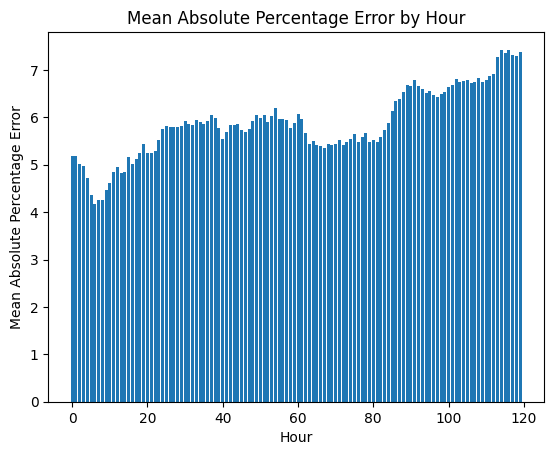

hour with highest mape: 116
highest hour mape: 7.42796117532466
hour with lowest mape: 6
lowest hour mape: 4.17802891092945
average hourly mape: 5.883148764567939
mape for 6th hour: 4.360518776226267


In [20]:


for i in range(len(temp.iloc[0]['y'])):
    for j in range(len(temp)):
        y = temp.iloc[j]['y']
        yhat = temp.iloc[j]['yhat']
        mape_i.append(np.mean(np.abs((y[i] - yhat[i]) / y[i])) * 100)
    mean_mape.append(np.mean(mape_i))
    mape_i = []

mean_mape

# plot this mean_mape as a bar chart to see where the highest and lowest are
import matplotlib.pyplot as plt

plt.bar(range(len(mean_mape)), mean_mape)
plt.xlabel('Hour')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('Mean Absolute Percentage Error by Hour')
plt.show()

# find index of the highest and lowest mape
max_index = mean_mape.index(max(mean_mape))
min_index = mean_mape.index(min(mean_mape))
print(f"hour with highest mape: {max_index}")
# print highest mape
print(f"highest hour mape: {max(mean_mape)}")

print(f"hour with lowest mape: {min_index}")
# print lowest mape
print(f"lowest hour mape: {min(mean_mape)}")

# print average mape
print(f"average hourly mape: {np.mean(mean_mape)}")

# if target_hour = 5, print mape for that hour
target_hour_index = 5 # 5 means actually 6th hour
print(f"mape for {target_hour_index+1}th hour: {mean_mape[target_hour_index]}")

In [21]:
# print average std_error
print(f"average std_error: {np.mean(temp['std_error'])}")

# print average rmspe
print(f"average rmspe: {np.mean(temp['rmspe'])}")

# print average pcg_same_dir
print(f"average pcg_same_dir: {np.mean(temp['pcg_same_dir'])}")
 

average std_error: 1430.515414783233
average rmspe: 6.37012684229885
average pcg_same_dir: 0.5060331825037706
